# 25-D Correlated Normal

## Setup

First, let's set up some environmental dependencies. These just make the numerics easier and adjust some of the plotting defaults to make things more legible.

In [1]:
# Python 3 compatability
from __future__ import division, print_function
from six.moves import range

# system functions that are always useful to have
import time, sys, os

# basic numeric setup
import numpy as np
from numpy import linalg

# inline plotting
%matplotlib inline

# plotting
import matplotlib
from matplotlib import pyplot as plt

# seed the random number generator
rstate = np.random.default_rng(21)

In [2]:
# re-defining plotting defaults
from matplotlib import rcParams
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'font.size': 30})

In [3]:
import dynesty

`dynesty` supports three tiers of sampling techniques: uniform sampling for low dimensional problems, random walks for low-to-moderate dimensional problems, and slice sampling for high-dimensional problems (with or without the use of gradients). Here we will quickly demonstrate that slice sampling is able to cope with high-dimensional problems using a 25-D correlated multivariate normal distribution.

In [4]:
ndim = 25  # number of dimensions
C = np.identity(ndim)  # set covariance to identity matrix
C[C==0] = 0.4  # set off-diagonal terms (strongly correlated)
Cinv = linalg.inv(C)  # precision matrix
lnorm = -0.5 * (np.log(2 * np.pi) * ndim + np.log(linalg.det(C)))  # ln(normalization)

# 3-D correlated multivariate normal log-likelihood
def loglikelihood(x):
    """Multivariate normal log-likelihood."""
    return -0.5 * np.dot(x, np.dot(Cinv, x)) + lnorm

# prior transform
def prior_transform(u):
    """Transforms our unit cube samples `u` to a flat prior between -5. and 5. in each variable."""
    return 5. * (2. * u - 1.)

# gradient of log-likelihood *with respect to u*
def gradient(x):
    """Multivariate normal log-likelihood gradient."""
    dlnl_dv = -np.dot(Cinv, x)  # standard gradient
    jac = np.diag(np.full_like(x, 10.))  # Jacobian
    return np.dot(jac, dlnl_dv)  # transformed gradient

# ln(evidence)
lnz_truth = -ndim * np.log(10. * 0.999999426697)
print(lnz_truth)

-57.56461299227203


Since we know this is a unimodal case, we'll initialize our sampler in the `'single'` bounding mode. 

In [5]:
# multivariate slice sampling ('slice')
sampler = dynesty.NestedSampler(loglikelihood, prior_transform, ndim, 
                                nlive=500, bound='single', 
                                sample='slice', slices=5, rstate=rstate)
sampler.run_nested(dlogz=0.01)
res = sampler.results

20502it [36:22,  9.40it/s, +500 | bound: 216 | nc: 1 | ncall: 12240254 | eff(%):  0.172 | loglstar:   -inf < -21.346 <    inf | logz: -57.705 +/-  0.236 | dlogz:  0.000 >  0.010]


In [6]:
# random slice sampling ('rslice')
sampler = dynesty.NestedSampler(loglikelihood, prior_transform, ndim,
                                nlive=500, bound='single', 
                                sample='rslice', slices=25,
                                rstate=rstate)
sampler.run_nested(dlogz=0.01)
res2 = sampler.results

20692it [06:16, 55.00it/s, +500 | bound: 99 | nc: 1 | ncall: 2503029 | eff(%):  0.847 | loglstar:   -inf < -20.831 <    inf | logz: -57.570 +/-  0.234 | dlogz:  0.000 >  0.010]


In [7]:
# hamiltonian slice sampling ('hslice')
sampler = dynesty.NestedSampler(loglikelihood, prior_transform, ndim,
                                nlive=500, bound='single',
                                sample='hslice', slices=5,
                                gradient=gradient, rstate=rstate)
sampler.run_nested(dlogz=0.01)
res3 = sampler.results

20588it [23:56, 14.33it/s, +500 | bound: 206 | nc: 1 | ncall: 13006565 | eff(%):  0.162 | loglstar:   -inf < -21.182 <    inf | logz: -57.714 +/-  0.235 | dlogz:  0.000 >  0.010]


Now let's see how we do.

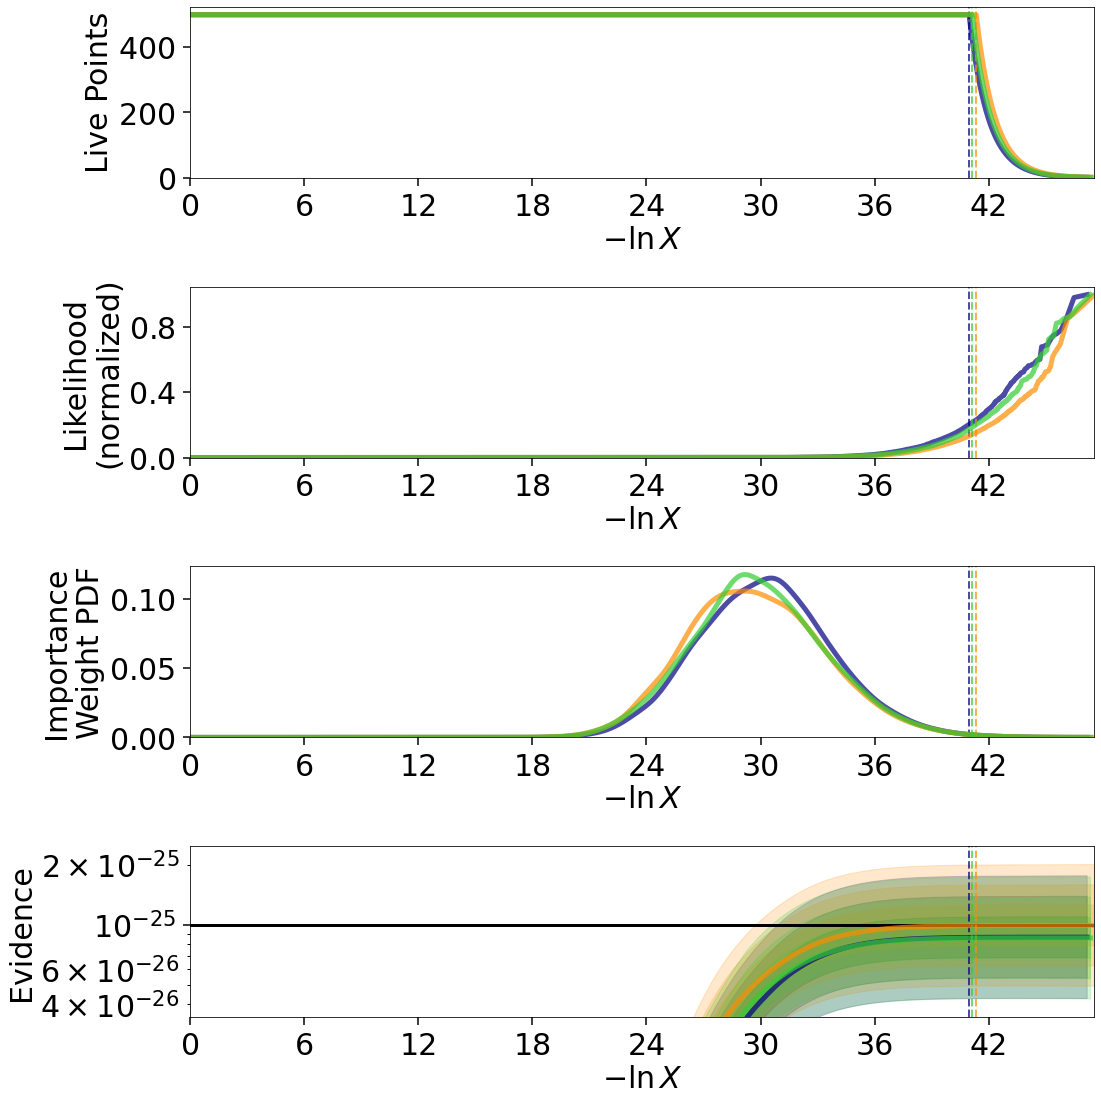

In [8]:
from dynesty import plotting as dyplot

fig, axes = dyplot.runplot(res, color='navy', logplot=True,
                           lnz_truth=lnz_truth, truth_color='black')
fig, axes = dyplot.runplot(res2, color='darkorange', logplot=True, fig=(fig, axes))
fig, axes = dyplot.runplot(res3, color='limegreen', logplot=True, fig=(fig, axes))
fig.tight_layout()

In [9]:
from dynesty import utils as dyfunc

print('Mean:')
print('slice:', dyfunc.mean_and_cov(res.samples, 
                                    np.exp(res.logwt-res.logz[-1]))[0])
print('rslice:', dyfunc.mean_and_cov(res2.samples, 
                                     np.exp(res2.logwt-res2.logz[-1]))[0])
print('hslice:', dyfunc.mean_and_cov(res3.samples, 
                                     np.exp(res3.logwt-res3.logz[-1]))[0])

print('\nVariance:')
print('slice:', np.diagonal(dyfunc.mean_and_cov(res.samples, 
                                                np.exp(res.logwt-res.logz[-1]))[1]))
print('rslice:', np.diagonal(dyfunc.mean_and_cov(res2.samples, 
                                                 np.exp(res2.logwt-res2.logz[-1]))[1]))
print('hslice:', np.diagonal(dyfunc.mean_and_cov(res3.samples, 
                                                 np.exp(res3.logwt-res3.logz[-1]))[1]))

Mean:
slice: [ 0.00080291  0.00406672 -0.00493006  0.00768341  0.01168745  0.00257284
 -0.00608764 -0.01331321  0.00302164  0.00739829  0.00267557  0.00882297
  0.01372292  0.00118094 -0.01034449 -0.01189181  0.00058856  0.01181997
 -0.00825656 -0.00345821 -0.01273608  0.00372074 -0.00297336  0.01811703
 -0.00099364]
rslice: [-0.03315893 -0.00432107  0.00998467 -0.01663759 -0.0046303  -0.0283778
 -0.01667174  0.00259521 -0.02423891 -0.04306577 -0.02425065 -0.01529905
 -0.00842877 -0.01335346  0.01843598 -0.01925403 -0.00792745 -0.01670167
 -0.01072673  0.01449257 -0.03352311  0.00877791  0.01324813 -0.00673466
  0.00528856]
hslice: [-0.00962847 -0.00294799 -0.01239019 -0.01733799 -0.00946174 -0.00521269
  0.0112683  -0.01446488 -0.01761637 -0.03406204 -0.02913731  0.00387279
 -0.01487945 -0.00976863 -0.01588725 -0.01137356  0.00906974 -0.0130511
 -0.00240558  0.01483746 -0.00522736 -0.01581743  0.00887628 -0.0120862
  0.01468354]

Variance:
slice: [0.98333744 0.97947349 0.98637122 0.95